# Case Background & Key Questions	

Flatiron Health Insurance (FHI) is a growing private healthcare insurance provider founded on the premise that using data and analytics can improve the health insurance industry by providing better care and offerings to its patients. Every year, the Center for Disease Control (CDC) conducts surveys to understand the latest demographic, health, and fitness trends. You have been tasked with analyzing the recently published results of his years’ survey and providing your recommendations back to the Chief Analytics Officer and Chief Marketing Officer. You have been assigned the task of taking a first look at the data and beginning to answer several key questions:
											 								
1)  How does health status, represented by average number of days with bad physical health in the past month (PHYSHLTH), differ by state? Also provide an indication of distribution using whatever statistics you find suitable.
 												 								
2)  Digging deeper into the data, what are some factors that impact health (i.e. demographics, behaviors, previous illness, etc.)?	
						 						
To get you started, the IT department formatted the data set into a tab delimited text file for only NY, NJ, and CT (FHI’s primary markets) called `case_studey.csv`. Below you will find a list of steps/questions that you will need to take in your investigation. The first part of the notebook will be focused on cleaning up your data and vidualizing it.  The second part of the data set will be focused on performing statistical tests to make statements with statistical significance.  


In [300]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# pd.read_csv('case_study.csv')

In [301]:
#Load our dataframe account for the index columns
df = pd.read_csv('case_study.csv', index_col=0)

/Users/judebuenaseda/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (171) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [302]:
df.head(10)

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
49938,9.0,5.0,5172017,5,17,2017,1200.0,2017000001,2.017000e+09,NaN,...,2.0,2.0,2.0,4.0,2.0,1.0,1.0,NaN,NaN,1.0
49939,9.0,2.0,2142017,2,14,2017,1200.0,2017000002,2.017000e+09,NaN,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,2.0
49940,9.0,1.0,1292017,1,29,2017,1200.0,2017000003,2.017000e+09,NaN,...,3.0,2.0,1.0,3.0,2.0,1.0,1.0,NaN,NaN,2.0
49941,9.0,7.0,9112017,9,11,2017,1200.0,2017000004,2.017000e+09,NaN,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,1.0
49942,9.0,5.0,7182017,7,18,2017,1200.0,2017000005,2.017000e+09,NaN,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0
49943,9.0,1.0,1192017,1,19,2017,1100.0,2017000006,2.017000e+09,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0
49944,9.0,1.0,2032017,2,3,2017,1100.0,2017000007,2.017000e+09,1.0,...,2.0,2.0,1.0,3.0,2.0,1.0,1.0,NaN,NaN,2.0
49945,9.0,1.0,2012017,2,1,2017,1100.0,2017000008,2.017000e+09,1.0,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,1.0
49946,9.0,1.0,1262017,1,26,2017,1100.0,2017000009,2.017000e+09,1.0,...,2.0,2.0,1.0,3.0,2.0,1.0,1.0,2.0,1.0,2.0
49947,9.0,1.0,1192017,1,19,2017,1100.0,2017000010,2.017000e+09,1.0,...,2.0,2.0,2.0,4.0,2.0,1.0,1.0,NaN,NaN,1.0


In [303]:
# Quickly check to see the size of our DF, both rows and columns
df.shape

(34545, 358)

## Subset your dataframe to only include the states in the tri-state area (NJ, CT, NY)

In [548]:
# your code here
#df[df['_STATE'] == ('NY' or 'Conn' or 'NJ')]

Now check to see how large our subset df.

In [7]:
# your code here

**PHYSHLTH** is the column we are interested in for this analysis, so let's start to investigate the column. Since we have a data cookbook, a.k.a. data dictionary) we want to start there before looking at the code.

In [305]:
df['PHYSHLTH'].describe()

count    34545.000000
mean        60.213403
std         37.504566
min          1.000000
25%         15.000000
50%         88.000000
75%         88.000000
max         99.000000
Name: PHYSHLTH, dtype: float64

## 1. Handle the non-normal values

As you can see from the data dictionary, there are a number of responses that are coded with values that could throw off our descriptive statistics.  Let's clean up by mapping the responses to a more appropriate value, and handling any missing values.  

In [7]:
df.columns

Index(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'CTELENM1',
       ...
       '_PA300R2', '_PA30021', '_PASTRNG', '_PAREC1', '_PASTAE1', '_RFSEAT2',
       '_RFSEAT3', '_FLSHOT6', '_PNEUMO2', '_AIDTST3'],
      dtype='object', length=358)

In [306]:
#your code here
zero_dict = {88:0,
             77: np.nan,
             99: np.nan}

df['PHYSHLTH'] = df['PHYSHLTH'].replace(zero_dict)

In [307]:
df_physhlth = df.dropna(subset=['PHYSHLTH'], inplace=True ) 

In [22]:
#df['PHYSHLTH']

In [308]:
#df_physhlth = df['PHYSHLTH']

In [309]:
#df_physhlth.head()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## 2. Generate the descriptive statistics

Now that our target variable is cleaned up lets calculate the descriptive statistics, generate a graph that quickly shows those statistics, and generate a graph shows the distribution of the data.

In [311]:
# descriptive statistics
df['PHYSHLTH'].describe()

count    33747.000000
mean         4.085341
std          8.513293
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         30.000000
Name: PHYSHLTH, dtype: float64

In [312]:
import seaborn as sns

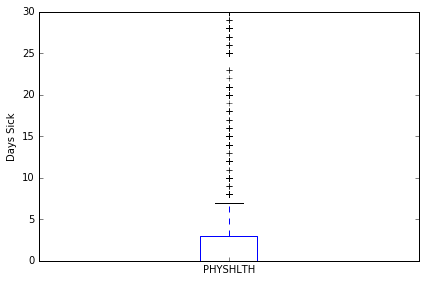

In [553]:
df['PHYSHLTH'].plot(kind='box')
plt.ylabel('Days Sick')

plt.tight_layout()
plt.show()

In [316]:
#sns.boxplot(df['PHYSHLTH']).set_title('boxplot')

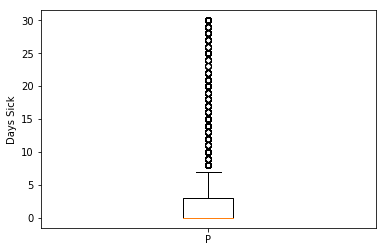

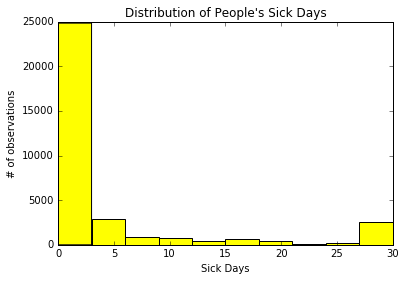

In [363]:
df['PHYSHLTH'].plot(kind='hist', color = 'yellow')
plt.title("Distribution of People's Sick Days")
plt.ylabel('# of observations')
plt.xlabel('Sick Days')
plt.show()

In [321]:
#sns.distplot(df['PHYSHLTH'],bins=range(0,30), kde=False).set_title("Distribution of People's Sick Days")

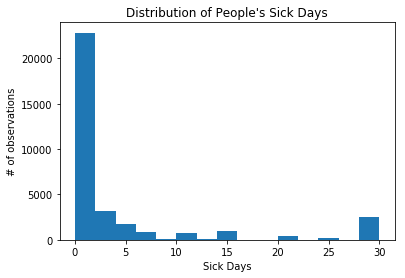

In [15]:
# graphic the distribution of data


## 3. Generate a graphic that compares the average number of sick days for each state. 

In [334]:
#df['_STATE'].value_counts()

In [342]:
df['_STATE'].replace(9.0, 'Conn', inplace=True)
df['_STATE'].replace(34.0, 'NJ', inplace=True)
df['_STATE'].replace(36.0, 'NY', inplace=True)

In [335]:
# code to calculate the average number of sick days by state
df_sickdays = df.groupby('_STATE')['PHYSHLTH'].agg('mean')
#df_sickdays

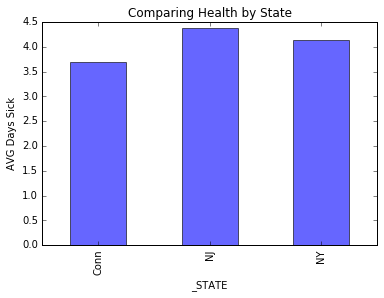

In [362]:
df_sickdays.plot(kind='bar', alpha=0.60)
plt.xticks([0, 1, 2], ['Conn', 'NJ', 'NY'])
plt.title('Comparing Health by State')
plt.ylabel('AVG Days Sick')
plt.show()

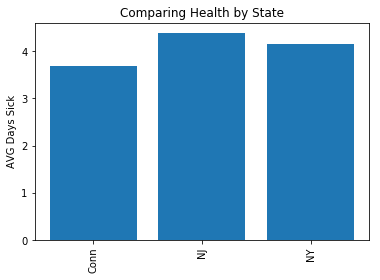

In [18]:
# code to graph those averages using matplotlib


In [338]:
#df.groupby('_STATE')['PHYSHLTH'].value_counts()

In [339]:
# histsick = df.groupby('_STATE')['PHYSHLTH'].value_counts()
# histsick = df.groupby('_STATE')['PHYSHLTH'].value_counts()

# histsick['Conn'].plot(kind='hist', alpha=0.5 )
# histsick['NJ'].plot(kind='hist', alpha=0.5)
# histsick['NY'].plot(kind='hist',alpha=0.5)
# plt.legend(['Conn', 'NJ', 'NY'])

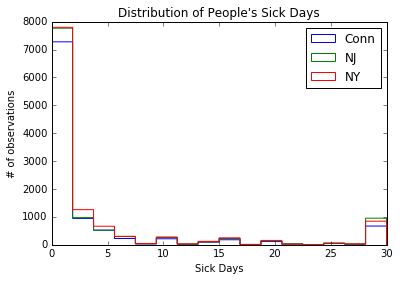

In [361]:
df.groupby('_STATE')['PHYSHLTH'].plot(kind='hist', histtype='step', bins=16)
plt.ylabel('# of observations')
plt.xlabel('Sick Days')
plt.title("Distribution of People's Sick Days")

plt.legend()
plt.show()

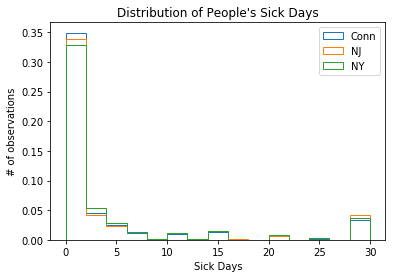

In [19]:
# graphic showing the histogram of data



## 4. Turn the number of sick days into a classification of of chronically sick people.  

Chronically sick people account for a significant proportion of the costs for health insurers. If we can identify what leads people to be chronically sick, we can address them with specific treatments.



In [355]:
# code to create new colum for chronically sick
df['Chronic_Sick'] = np.where(df['PHYSHLTH'].values > 10, 1, 0)
#df['Chronic_Sick'].head()

## 5. Create a graphic that compares the percentage of people labeled as 'sick' in each state. 

In [356]:
# code to calculate averages per state
df_cs = df.groupby('_STATE')['Chronic_Sick'].mean()
#df_cs

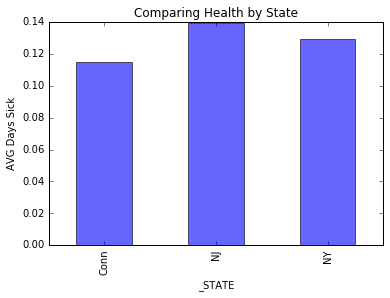

In [365]:
df_cs.plot(kind='bar', alpha=0.60)
#plt.xticks([0, 1, 2], ['Conn', 'NJ', 'NY'])
plt.title('Comparing Health by State')
plt.ylabel('AVG Days Sick')
plt.show()

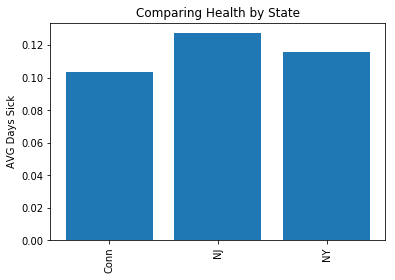

In [24]:
# create graphic to compare chronically sick by state


## 6. Independent Variables (categorical)

Does smoking affect the number of days people feel physically ill? 
Let's take the column `SMOKDAY2` and start to prepare it so that we can see how it is possibly correlated to `PHYSHLTH`. When cleaning this data you will find that many respondents were not asked that question. read the codebook to understand why, and use that information when cleaning up your data. I.E, you will need to process two columns in order to create a new column of smokers.

1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Generate a graphic that compares the physical health of the different groups of 'smokers'.

In [559]:
conditions = [((df['SMOKE100'] == 1.0) & (df['SMOKDAY2'] == 1.0)),
              ((df['SMOKE100'] == 1.0) & (df['SMOKDAY2'] == 2.0)), 
              ((df['SMOKE100'] == 1.0) & (df['SMOKDAY2'] == 3.0)),
              df['SMOKE100'] == 2.0]

choices = ['Every Day', 'Some Days', 'Former', 'Never']

df['SMOKER'] = np.select(conditions, choices, default='Unknown')

In [120]:
# np_dict = {9: np.nan,
#            7: np.nan}

# df['SMOKDAY2'] = df['SMOKDAY2'].replace(np_dict)

In [391]:
#df.dropna(subset=['SMOKDAY2'], inplace=True)

In [390]:
df['SMOKDAY2'].isnull().sum()

0

In [538]:
df['SMOKDAY2'].value_counts()

non      5943
every    1440
some      843
9.0         6
7.0         4
Name: SMOKDAY2, dtype: int64

In [395]:
smoking = df['SMOKDAY2'].value_counts()

In [398]:
df['Smoka'] = np.where(df['SMOKDAY2'].values < 3, 1, 0)

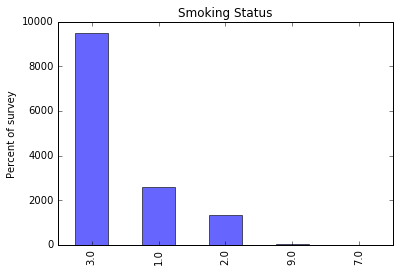

In [411]:
smoking.plot(kind='bar', alpha=0.60)
#plt.xticks([0, 1, 2, 3, 4], ['Not at all', 'Everyday', 'Some Days', "Don't Know", 'Refused'])
plt.title('Smoking Status')
plt.ylabel('Percent of survey')


plt.tight_layout
plt.show()

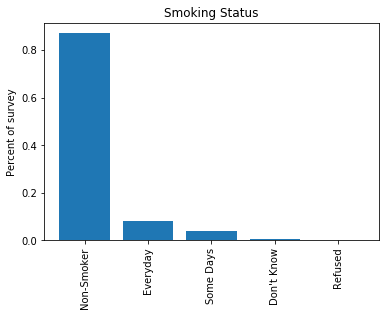

In [52]:
# code to graph those proportion of differen smoking groups using matplotlib


In [417]:
df.groupby('_STATE')['Smoka'].value_counts()

_STATE  Smoka
Conn    0        3174
        1        1050
NJ      0        3252
        1        1381
NY      0        3095
        1        1516
Name: Smoka, dtype: int64

In [454]:
# df_s.plot(kind='bar', alpha=0.60, stacked=True)
# plt.title('Smoking Status')
# plt.ylabel('Percent of survey')


# plt.legend(['Smoker', 'NonSmoker'])
# plt.show()

In [429]:
df['SMOKDAY2'].replace(3.0, 'non', inplace=True)
df['SMOKDAY2'].replace(1.0, 'every', inplace=True)
df['SMOKDAY2'].replace(2.0, 'some', inplace=True)

In [430]:
cat = list(df['SMOKDAY2'].unique())

In [431]:
unknown_category = [7, 9]
category = [x for x in cat if x not in unknown_category ]

In [432]:
category

['non', 'every', 'some']

In [433]:
unknown_dict = dict.fromkeys(unknown_category, 'unknown')

In [434]:
cat_dict = dict(zip(category, category))

In [435]:
#combine those ditionaries into 1
category_map = {**cat_dict,**unknown_dict}
category_map

{9: 'unknown', 'every': 'every', 'some': 'some', 'non': 'non', 7: 'unknown'}

In [436]:
# use the pandas map function to change the content_rating column
df['category'] = df['SMOKDAY2'].map(category_map)

In [455]:
#df.groupby('_STATE')['category'].value_counts()

In [467]:
stacked = df.groupby('_STATE')['category'].value_counts(normalize=True)*100
stacked.unstack()

category,every,non,some,unknown
_STATE,,,,
Conn,16.714015,74.952652,8.143939,0.189394
NJ,19.447442,70.127347,10.360458,0.064753
NY,21.774019,66.775103,11.103882,0.346996


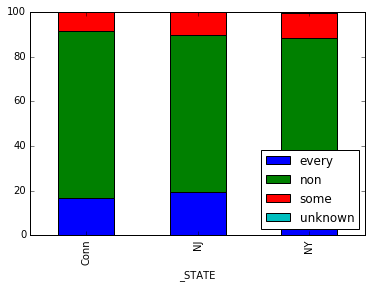

In [468]:
#df[['category', 'SMOKDAY2']].tail()
stacked.unstack().plot(kind='bar', stacked=True)
plt.legend(loc=4)

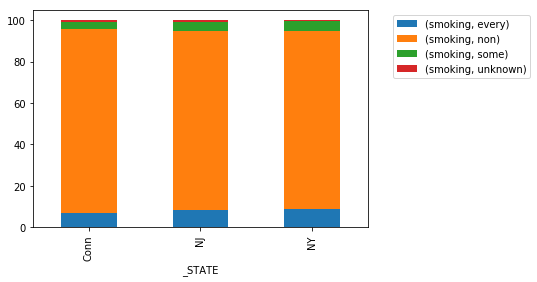

In [63]:
#graph showing the breakdown of smokers per state

In [447]:
smoking_avg = df.groupby('category')['PHYSHLTH'].agg('mean')
smoking_avg

category
every      6.653007
non        4.581841
some       6.295659
unknown    5.592593
Name: PHYSHLTH, dtype: float64

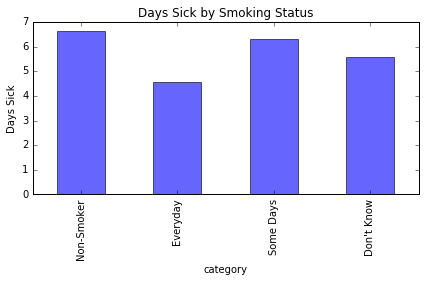

In [453]:
smoking_avg.plot(kind='bar', alpha=0.60)
plt.xticks([0, 1, 2, 3], ['Non-Smoker', 'Everyday', 'Some Days', "Don't Know"])
plt.title('Days Sick by Smoking Status')
plt.ylabel('Days Sick')


plt.tight_layout()
plt.show()

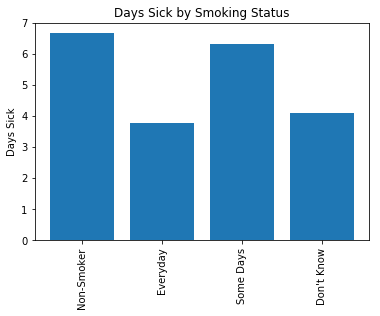

In [65]:
# code to graph these averages sick days for each category of smoking status

## 7. Independent Variables (continuous):

Does the amount of days a person drinks affect the number of days they feel physically ill?
To investigate this, let's look at a continuous variable (ALCDAY5) and see how that might impact a person's health. 

1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Calculate the correlation coefficient between `PHYSHLTH` and `ALCDAY5`.
5. Generate a graphic that shows the possible relationship between `PHYSHLTH` and `ALCDAY5`.

In [ ]:
# zero_dict = {88:0,
#              77: np.nan,
#              99: np.nan}

# df['PHYSHLTH'] = df['PHYSHLTH'].replace(zero_dict)

# df_physhlth = df.dropna(subset=['PHYSHLTH'], inplace=True ) 

In [178]:
alc_dict = {888: 0,
            777: np.nan,
            999: np.nan}

#df['ALCDAY5'] = df['ALCDAY5'].replace(alc_dict)

#df.dropna(subset=['ALCDAY5'], inplace=True)

In [563]:
df['Alcohol'] = np.where(df['ALCDAY5'].values >= 200, (df['ALCDAY5'].values-200), 
                         ((df['ALCDAY5'].values-100)*4.34524))

In [564]:
df['Alcohol'].head()

49942     4.34524
49944    30.00000
49954     2.00000
49956    30.41668
49959     3.00000
Name: Alcohol, dtype: float64

In [521]:
nonvalue_dict = {688.0: np.nan,
                 577.0: np.nan,
                 799.0: np.nan}

df['Alcohol'] = df['Alcohol'].replace(nonvalue_dict)

In [522]:
df.dropna(subset=['Alcohol'], inplace=True)

In [533]:
#df['Alcohol'].value_counts()

In [477]:
#df[df['ALCDAY5'].isnull()==True]

In [536]:
#df.groupby('_STATE')['Alcohol'].value_counts()
#df.isnull().sum()

In [524]:
df['Alcohol'].describe()

count    8236.000000
mean        7.500607
std         8.968277
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        30.000000
Name: Alcohol, dtype: float64

In [73]:
#descriptive statistics of cleaned data

count    31532.000000
mean         5.504455
std          8.450005
min          0.000000
25%          0.000000
50%          2.000000
75%          7.000000
max         30.416680
Name: alcohol, dtype: float64

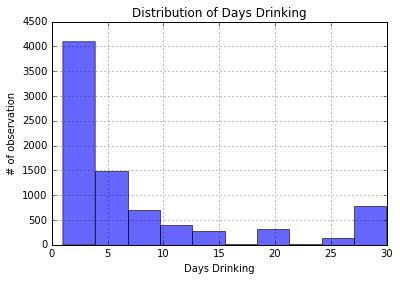

In [528]:
df['Alcohol'].hist(alpha=0.6)
plt.title('Distribution of Days Drinking')
plt.xlabel('Days Drinking')
plt.ylabel('# of observation')

plt.tight_layout
plt.show()

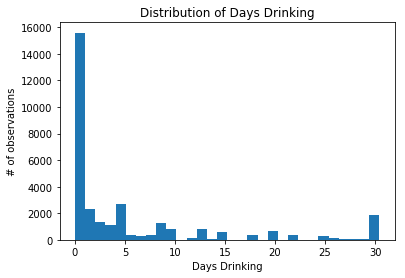

In [75]:
# graphic showing the histogram of data


In [530]:
# code to calculate averages per state
df.groupby('_STATE')['Alcohol'].mean()

_STATE
Conn    8.185144
NJ      7.026715
NY      7.313599
Name: Alcohol, dtype: float64

In [194]:

# s1 = pd.Series([.2, .0, .6, .2])

# s2 = pd.Series([.3, .6, .0, .1])

# s1.corr(s2, method=pearson)
# 0.3

In [529]:
series1 = df['PHYSHLTH']
series2 = df['Alcohol']

print('Pearson R is', series1.corr(series2, method='pearson'))


Pearson R is -0.00828635973335


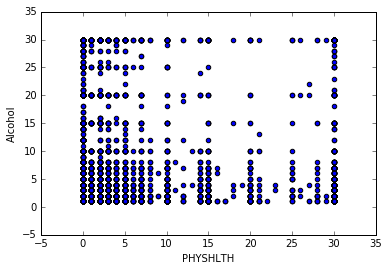

In [532]:
df.plot(x ='PHYSHLTH', y='Alcohol', kind = 'scatter')
plt.show()

In [83]:
# Code to calculate correlation of between number of dirnks of number of days physically ill



PHYSHLTH    1.000000
alcohol    -0.091016
Name: PHYSHLTH, dtype: float64

## 8. Statistical Inference


- Create a 95% confidence interval for the population mean of physically ill days.

-  Create a 95% confidence interval for the true proportion of chronically sick people.

## 9. Hypothesis Tests 

**For the follwing questions that require hypothesis tests, you must complete the following:**

*1. Write down the null and alternative hypothesis you are testing.* 

*2. Select the appropriate test and calculate the test statistic and P-values.*

*3. Determine the critical value for the 95% confidence interval.*

*4. Evaluate the test statistic agains the critical value.*

*5. Determine if you reject or fail to reject the null hypothesis and write a sentence explaining the results of your hypothesis test.*  

### The following questions are regarding the `PHYSHLTH` variable. 
- What is the probability of getting this sample mean for days physically ill, if the population mean is 4?
- Is there a statistically significant difference between men and women in the number of days a person feels phsyically ill?
- Perform a statistical test to determine if there statistically significant difference is physical health of people from the three states. 


### The following questions are regarding the  `CHRONIC` variable.
- What is the probability of drawing this sample proportion if chronically true population proportion is 0.10?
- Is there a statistically significant difference in the percentage of men and women who are chronically sick?
- Perform a statistical test to determine if there statistically significant difference is physical health of people from the three states.

# 10. Independent Investigation

Now that you have invesitgated physical health and chronic sickness and their relationships with states and gender, you will conduct a similar investigation with variables of your choosing. 

Select a continuous dependent varaible and a binary dependent variable that you would like to investigate. Then select a categorical independent variable with at least 3 groups and for which you will test to see if the response to the independent variable affects outcomes of the dependent variable.

For your continuous dependent variable perform the following:
  - Determine the sample mean and sample standard deviation
  - Create a confidence interval for a population mean.
  - Perform a two-sample test of means for gender.
  - Perform a one-way ANOVA using your categorical independent variable.

Select/create a binary variable from the survey questions as you dependent variable and perform the following:
  - Create a confidence interval for a population proportion.
  - Perform a two proportions z-test using gender.
  - Perform a Chi-Square test using your categorical independent variable.